## 0. Libarary 불러오기 및 경로설정

In [1]:
# Baseline
from EDA import show_images
from dataset import convert_to_dataloader, ImageAugmentation
from dataset import MaskSplitByProfileDataset, TestDataset
from loss import F1Loss, FocalLoss
from train import seed_everything, train, eval
from inference import test

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image # tensor to pil_image
import torchvision.models as models
import torchvision.transforms as T
%matplotlib inline

In [2]:
# 데이터셋 폴더 경로를 지정
train_dir = '../../../../input/data/train'
images_dir = '../../../../input/data/train/images'

test_dir = '../../../../input/data/eval'
model_dir = '../../../../code/models'

In [3]:
print(f"CUDA: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA: True


In [66]:
BATCH_SIZE = 70
LR = 0.0001
EPOCH = 5

seed_everything(42)
CLASS_NUM = 18

In [5]:
train_csv = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_csv.tail(3)

,id,gender,race,age,path
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20
2699,006959,male,Asian,19,006959_male_Asian_19


# EDA

In [62]:
ds = MaskSplitByProfileDataset(images_dir, 0.2)

In [88]:
# ColorJitter(brightness=0~1, contrast=0~1, saturation=0~1, hue=0~1)
transform = transforms.Compose([
    T.CenterCrop((320, 256)),
    ToTensor(),
    T.ColorJitter(0.1, 0.7, 1, 0.1),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
ds.set_transform(transform)

In [86]:
indexs = [7, 85, 44, 2595, 15000, 342, 234]

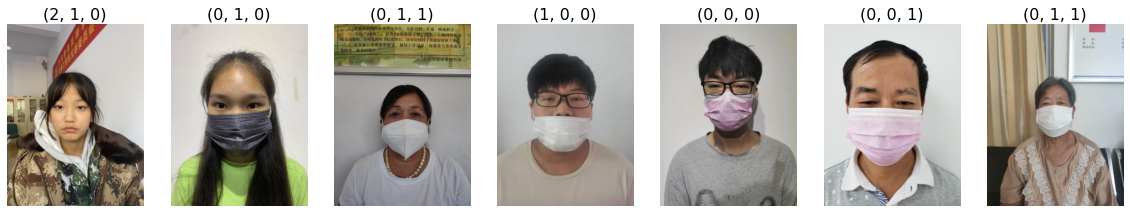

In [87]:
show_images(ds, indexs, 1, len(indexs)) # ColorJitter(0.1, 0.7, 0, 0.1)

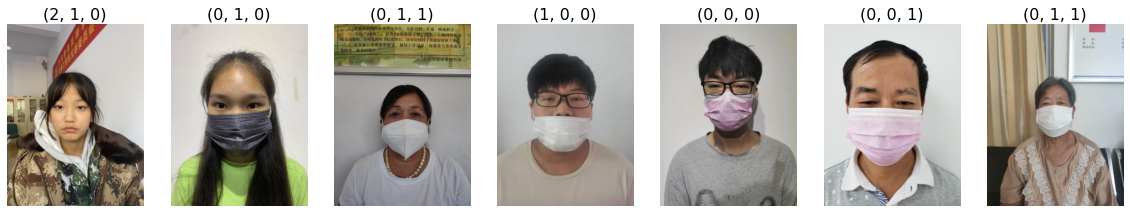

In [89]:
show_images(ds, indexs, 1, len(indexs)) # ColorJitter(0.1, 0.7, 1, 0.1)

## 1. Model 정의

In [64]:
train_ss, eval_ss = ds.split_dataset()

len(train_ss), len(eval_ss)

(15477, 3423)

In [65]:
train_loader = convert_to_dataloader(train_ss.dataset, BATCH_SIZE, True)
eval_loader = convert_to_dataloader(eval_ss.dataset, BATCH_SIZE, True)

len(train_loader)*BATCH_SIZE, len(eval_loader)*BATCH_SIZE

(151200, 151200)

In [ ]:
model = models.resnet18(pretrained=True).to(device)
loss_fn = FocalLoss()
optm = torch.optim.Adam(model.parameters(), lr=LR)

# resnet dense-layer 
model.fc = nn.Linear(model.fc.in_features, CLASS_NUM).to(device)

nn.init.xavier_uniform_(model.fc.weight) # weight= Xavier init
stdv = np.sqrt(1 / model.fc.in_features)
model.fc.bias.data.uniform_(-stdv, stdv) # bias= Uniform init

# for x in model.children():
#     print(x)

In [ ]:
train(train_loader, model, loss_fn, optm, EPOCH)

In [ ]:
eval(eval_loader, model)

## 2. Test Dataset 정의

## 3. Inference

In [ ]:
# torch.save(model, os.path.join(model_dir, "resnet34_crossentropy_adam.pt"))
# model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

In [ ]:
model_name = str(model).split('(')[0]
loss_name = str(loss_fn).split('(')[0]
optm_name = str(optm).split(' ')[0]

In [ ]:
# test(test_dir, model, transform, saving_filename=f'{model_name}_{loss_name}_{optm_name}.csv')